In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import generic_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
path = '/home/jun/Data/weatherImageRecognition/dataset'
path_imgs = list(glob.glob(path+'/**/*.jpg'))

In [4]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

File_Path   Labels
0  /home/jun/Data/weatherImageRecognition/dataset...  rainbow
1  /home/jun/Data/weatherImageRecognition/dataset...     hail
2  /home/jun/Data/weatherImageRecognition/dataset...    frost
3  /home/jun/Data/weatherImageRecognition/dataset...     rime
4  /home/jun/Data/weatherImageRecognition/dataset...      dew

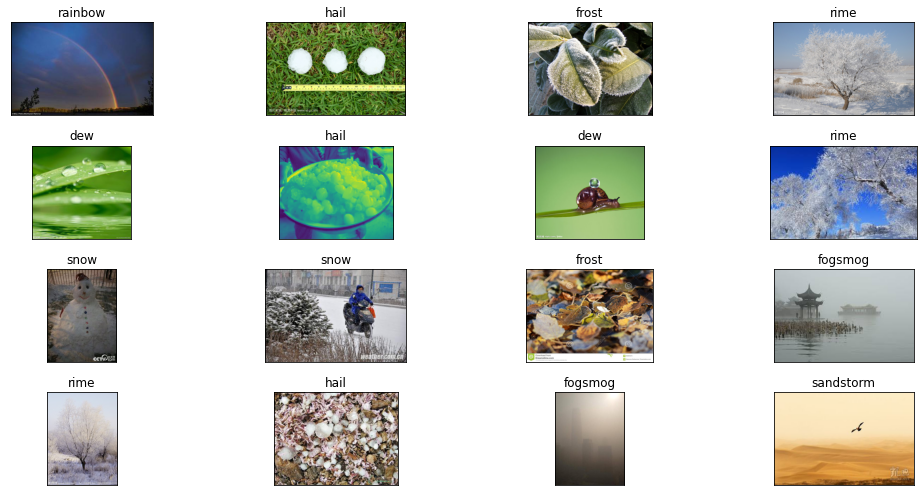

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

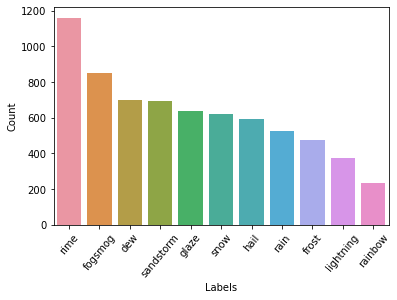

In [6]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [7]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)


In [8]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

In [9]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [10]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [11]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

In [16]:
!pip install tf-nightly

     |████████████████████████████████| 492.1 MB 7.5 kB/s eta 0:00:01     |█████████████████▍              | 267.3 MB 3.5 MB/s eta 0:01:04     |██████████████████████▏         | 340.8 MB 3.4 MB/s eta 0:00:46
  Using cached tensorflow_io_gcs_filesystem-0.23.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
  Using cached libclang-12.0.0-2-py2.py3-none-manylinux1_x86_64.whl (13.3 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 1.5 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 4.2 MB/s eta 0:00:01
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
     |████████████████████████████████| 462 kB 5.5 MB/s eta 0:00:01
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.10.0
    Uninstalling absl-py-0.10.0:
      S

In [ ]:
!pip install -U efficientnet

     |████████████▍                   | 5.3 MB 1.3 MB/s eta 0:00:07

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.


2022-01-27 00:25:48.498376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-27 00:25:48.498579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-27 00:25:48.498723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-27 00:25:48.893802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-01-27 00:25:48.894019: W tensorflow/stream_executor/platform/default/dso_loader

258076736/258076736 [==============================] - 61s 0us/step


2022-01-27 00:27:19.457996: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 63922176 exceeds 10% of free system memory.
2022-01-27 00:27:20.231573: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 63922176 exceeds 10% of free system memory.
2022-01-27 00:27:21.037328: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 63922176 exceeds 10% of free system memory.
2022-01-27 00:27:21.846069: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 63922176 exceeds 10% of free system memory.
2022-01-27 00:27:22.683119: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 63922176 exceeds 10% of free system memory.


43/43 [==============================] - 35s 699ms/step
              precision    recall  f1-score   support

         dew       0.87      0.88      0.88       137
     fogsmog       0.66      0.80      0.72       181
       frost       0.66      0.55      0.60       108
       glaze       0.48      0.76      0.59       119
        hail       0.96      0.76      0.85       105
   lightning       0.92      0.64      0.75        69
        rain       0.79      0.80      0.80       117
     rainbow       1.00      0.76      0.86        50
        rime       0.89      0.78      0.83       238
   sandstorm       0.73      0.74      0.73       133
        snow       0.68      0.61      0.64       116

    accuracy                           0.75      1373
   macro avg       0.79      0.74      0.75      1373
weighted avg       0.77      0.75      0.75      1373



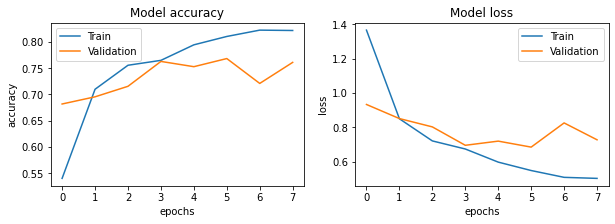

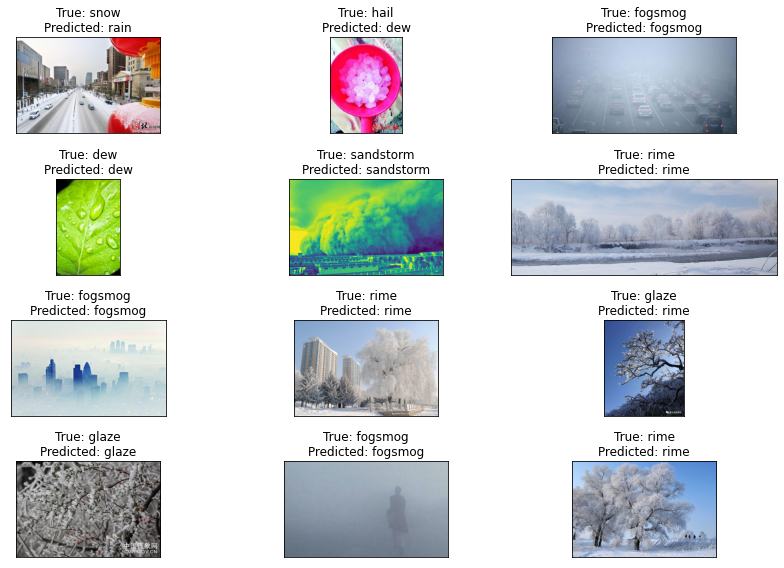

    Test Loss: 0.75978
Test Accuracy: 74.80%


In [12]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
ENet_pre=preprocess_input
train_gen_ENet, valid_gen_ENet, test_gen_ENet = gen(ENet_pre,train_df,test_df)
ENet_model, callback=func(EfficientNetB7)
history = ENet_model.fit(
    train_gen_ENet,
    validation_data=valid_gen_ENet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_ENet=plot(history,test_gen_ENet,train_gen_ENet, ENet_model)

result_ENet = result_test(test_gen_ENet,ENet_model)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 13s 272ms/step
              precision    recall  f1-score   support

         dew       0.85      0.96      0.90       137
     fogsmog       0.88      0.92      0.90       181
       frost       0.79      0.62      0.69       108
       glaze       0.70      0.79      0.74       119
        hail       0.90      0.88      0.89       105
   lightning       0.94      0.93      0.93        69
        rain       0.93      0.72      0.81       117
     rainbow       1.00      0.90      0.95        50
        rime       0.86      0.86      0.86       238
   sandstorm       0.90      0.89      0.89       133
        snow       0.62      0.73      0.67       116

    accuracy                           0.84      1373
   macro avg       0.85      0.83      0.84      1373


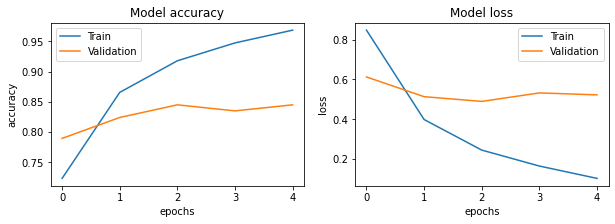

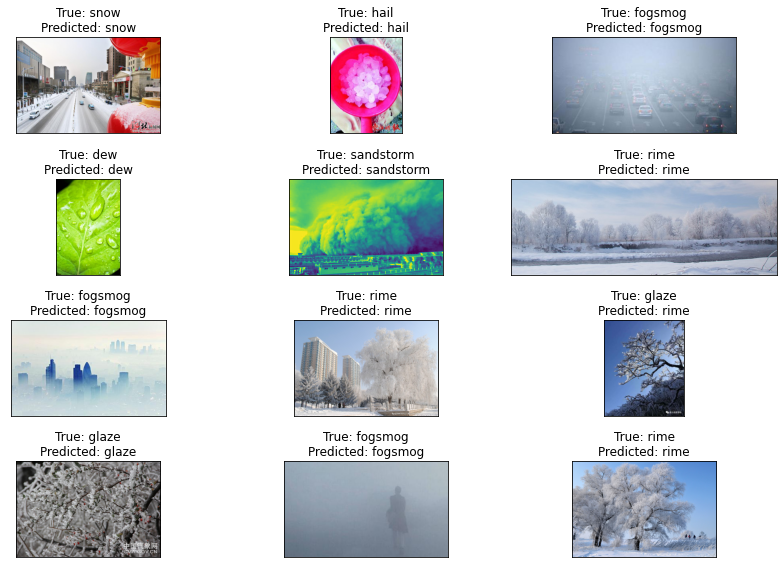

    Test Loss: 0.55252
Test Accuracy: 83.76%


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet_pre=preprocess_input
train_gen_ResNet, valid_gen_ResNet, test_gen_ResNet = gen(ResNet_pre,train_df,test_df)
ResNet_model, callback=func(ResNet50)
history = ResNet_model.fit(
    train_gen_ResNet,
    validation_data=valid_gen_ResNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_ResNet= plot(history,test_gen_ResNet,train_gen_ResNet, ResNet_model)

result_ResNet = result_test(test_gen_ResNet,ResNet_model)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 9s 197ms/step
              precision    recall  f1-score   support

         dew       0.87      0.91      0.89       137
     fogsmog       0.88      0.81      0.84       181
       frost       0.80      0.62      0.70       108
       glaze       0.61      0.70      0.65       119
        hail       0.78      0.90      0.83       105
   lightning       0.94      0.90      0.92        69
        rain       0.77      0.76      0.77       117
     rainbow       1.00      1.00      1.00        50
        rime       0.79      0.90      0.84       238
   sandstorm       0.83      0.86      0.85       133
        snow       0.84      0.59      0.70       116

    accuracy                           0.81      1373
   macro avg       0.83      0.81      0.82      1373
w

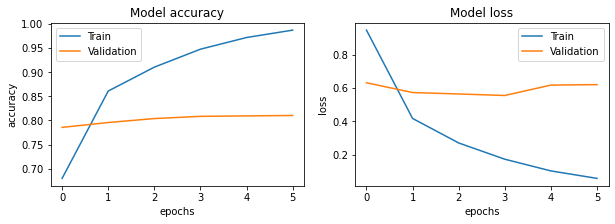

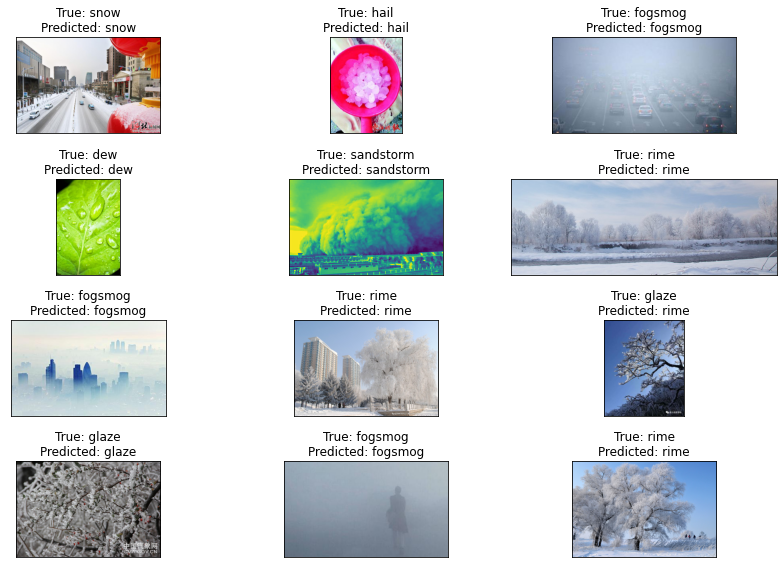

    Test Loss: 0.73807
Test Accuracy: 81.28%


In [14]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model, callback=func(MobileNet)
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 26s 599ms/step
              precision    recall  f1-score   support

         dew       0.85      0.82      0.83       137
     fogsmog       0.83      0.90      0.86       181
       frost       0.67      0.61      0.64       108
       glaze       0.62      0.68      0.65       119
        hail       0.87      0.80      0.83       105
   lightning       0.80      0.94      0.87        69
        rain       0.78      0.74      0.76       117
     rainbow       0.97      0.66      0.79        50
        rime       0.83      0.85      0.84       238
   sandstorm       0.90      0.86      0.88       133
        snow       0.62      0.66      0.64       116

    accuracy                           0.79      1373
   macro avg       0.79      0.77      0.78      1373


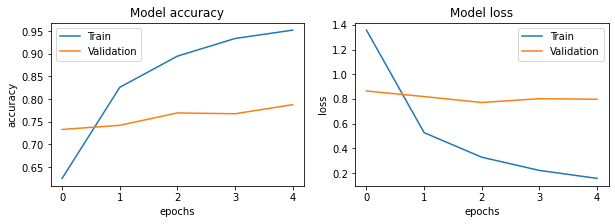

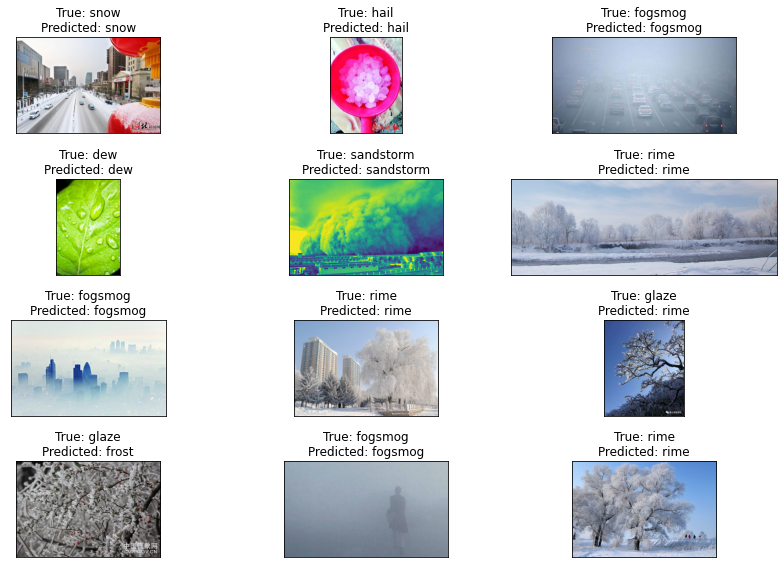

    Test Loss: 0.74395
Test Accuracy: 78.81%


In [15]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
VGG19_pre=preprocess_input
train_gen_VGG19, valid_gen_VGG19, test_gen_VGG19 = gen(VGG19_pre,train_df,test_df)
VGG19_model, callback=func(VGG19)
history = VGG19_model.fit(
    train_gen_VGG19,
    validation_data=valid_gen_VGG19,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_VGG19= plot(history,test_gen_VGG19,train_gen_VGG19, VGG19_model)

result_VGG19 = result_test(test_gen_VGG19,VGG19_model)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 12s 259ms/step
              precision    recall  f1-score   support

         dew       0.81      0.83      0.82       137
     fogsmog       0.83      0.74      0.78       181
       frost       0.65      0.61      0.63       108
       glaze       0.67      0.64      0.66       119
        hail       0.92      0.68      0.78       105
   lightning       0.82      0.96      0.89        69
        rain       0.88      0.74      0.80       117
     rainbow       0.88      0.86      0.87        50
        rime       0.79      0.84      0.82       238
   sandstorm       0.69      0.83      0.75       133
        snow       0.61      0.73      0.67       116

    accuracy                           0.77      1373
   macro avg       0.78      0.77      0.77      1373


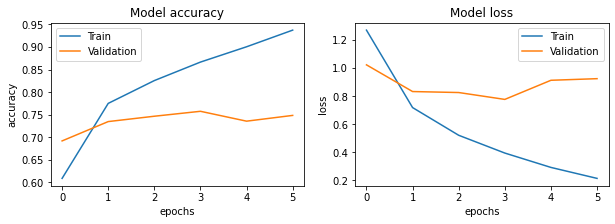

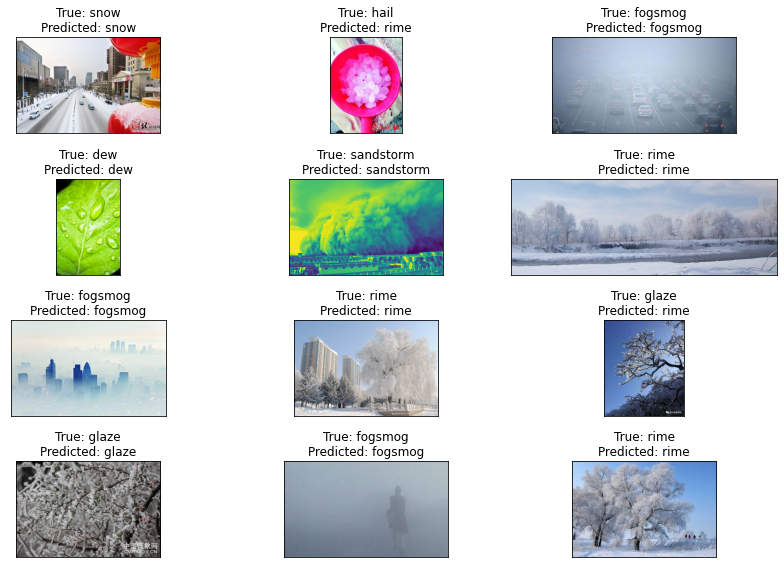

    Test Loss: 0.92989
Test Accuracy: 76.62%


In [16]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)
Xception_model, callback=func(Xception)
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_Xception = plot(history,test_gen_Xception,train_gen_Xception, Xception_model)
result_Xception = result_tresult_Xception = result_test(test_gen_Xception,Xception_model)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 23s 477ms/step
              precision    recall  f1-score   support

         dew       0.80      0.87      0.84       137
     fogsmog       0.80      0.75      0.78       181
       frost       0.72      0.45      0.56       108
       glaze       0.56      0.57      0.57       119
        hail       0.80      0.86      0.83       105
   lightning       0.91      0.88      0.90        69
        rain       0.59      0.68      0.63       117
     rainbow       0.91      0.84      0.87        50
        rime       0.74      0.88      0.80       238
   sandstorm       0.75      0.74      0.75       133
        snow       0.53      0.42      0.47       116

    accuracy                           0.73      1373
   macro avg       0.74      0.72      0.73      1373


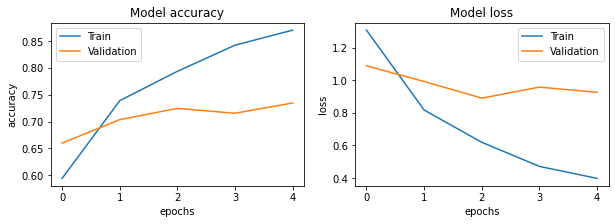

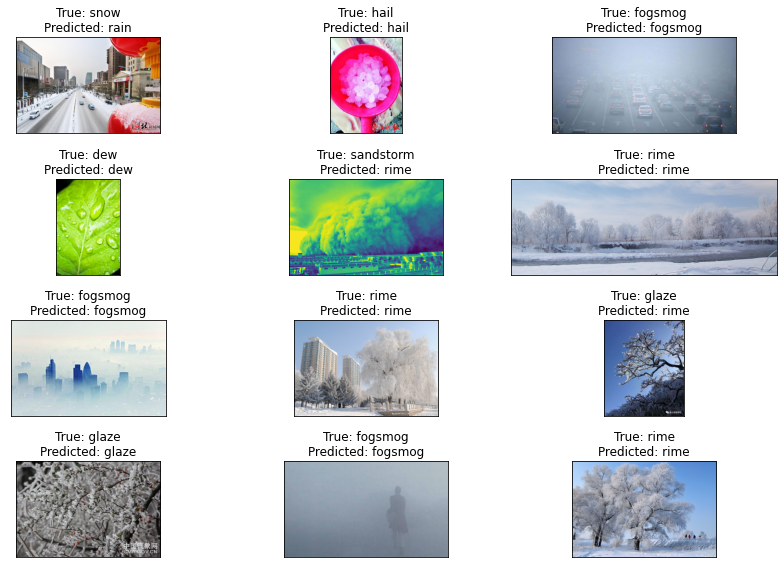

    Test Loss: 0.94652
Test Accuracy: 72.91%


In [17]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
IRNV2_pre=preprocess_input
train_gen_IRNV2, valid_gen_IRNV2, test_gen_IRNV2 = gen(IRNV2_pre,train_df,test_df)
IRNV2_model, callback=func(InceptionResNetV2)
history = IRNV2_model.fit(
    train_gen_IRNV2,
    validation_data=valid_gen_IRNV2,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_IRNV2 =plot(history,test_gen_IRNV2,train_gen_IRNV2, IRNV2_model)
result_IRNV2 = result_tresult_IRNV2 = result_test(test_gen_IRNV2,IRNV2_model)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 33s 745ms/step
              precision    recall  f1-score   support

         dew       0.90      0.86      0.88       137
     fogsmog       0.84      0.84      0.84       181
       frost       0.65      0.59      0.62       108
       glaze       0.62      0.61      0.62       119
        hail       0.85      0.86      0.85       105
   lightning       0.93      0.91      0.92        69
        rain       0.81      0.81      0.81       117
     rainbow       0.92      0.88      0.90        50
        rime       0.79      0.89      0.83       238
   sandstorm       0.87      0.83      0.85       133
        snow       0.63      0.60      0.62       116

    accuracy                           0.79      1373
   macro avg       0.80      0.79      0.79      1373


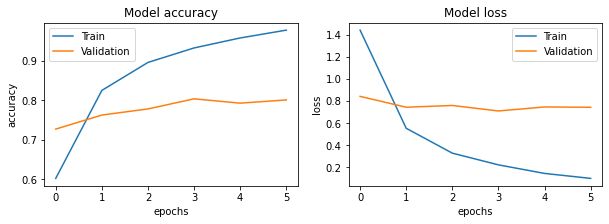

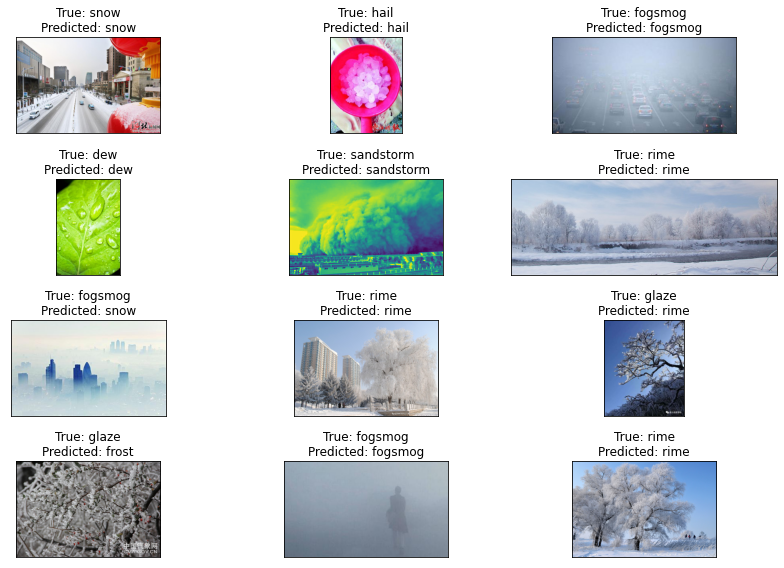

    Test Loss: 0.76420
Test Accuracy: 79.39%


In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)
model_VGG16, callback=func(VGG16)
history = model_VGG16.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_VGG,train_gen_VGG, model_VGG16)
result_VGG16 = result_test(test_gen_VGG,model_VGG16)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 39s 840ms/step
              precision    recall  f1-score   support

         dew       0.92      0.90      0.91       137
     fogsmog       0.92      0.85      0.88       181
       frost       0.84      0.61      0.71       108
       glaze       0.68      0.69      0.68       119
        hail       0.87      0.90      0.88       105
   lightning       0.90      0.96      0.93        69
        rain       0.88      0.80      0.84       117
     rainbow       1.00      0.86      0.92        50
        rime       0.77      0.95      0.85       238
   sandstorm       0.89      0.91      0.90       133
        snow       0.74      0.72      0.73       116

    accuracy                           0.84      1373
   macro avg       0.85      0.83      0.84      1373


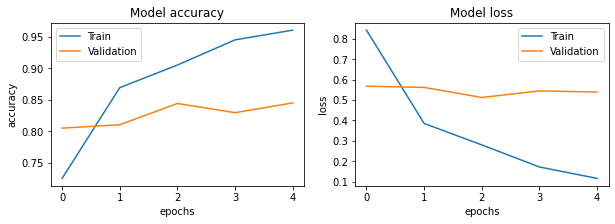

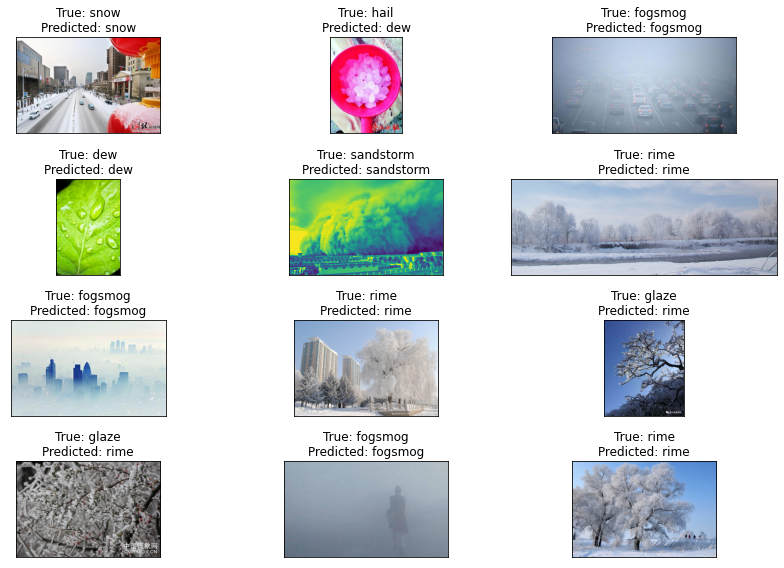

    Test Loss: 0.58089
Test Accuracy: 83.76%


In [19]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

ResNet101_pre=preprocess_input
train_gen_ResNet101, valid_gen_ResNet101, test_gen_ResNet101 = gen(ResNet101_pre,train_df,test_df)
model_ResNet101, callback=func(ResNet101)
history = model_ResNet101.fit(
    train_gen_ResNet101,
    validation_data=valid_gen_ResNet101,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_ResNet101,train_gen_ResNet101, model_ResNet101)
result_ResNet101 = result_test(test_gen_ResNet101,model_ResNet101)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 26s 520ms/step
              precision    recall  f1-score   support

         dew       0.95      0.85      0.90       137
     fogsmog       0.85      0.86      0.86       181
       frost       0.71      0.72      0.72       108
       glaze       0.69      0.64      0.66       119
        hail       0.92      0.84      0.88       105
   lightning       0.96      0.96      0.96        69
        rain       0.80      0.79      0.80       117
     rainbow       0.96      0.94      0.95        50
        rime       0.80      0.87      0.84       238
   sandstorm       0.93      0.86      0.89       133
        snow       0.61      0.71      0.66       116

    accuracy                           0.82      1373
   macro avg       0.83      0.82      0.83      1373


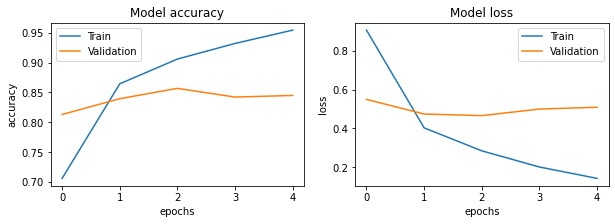

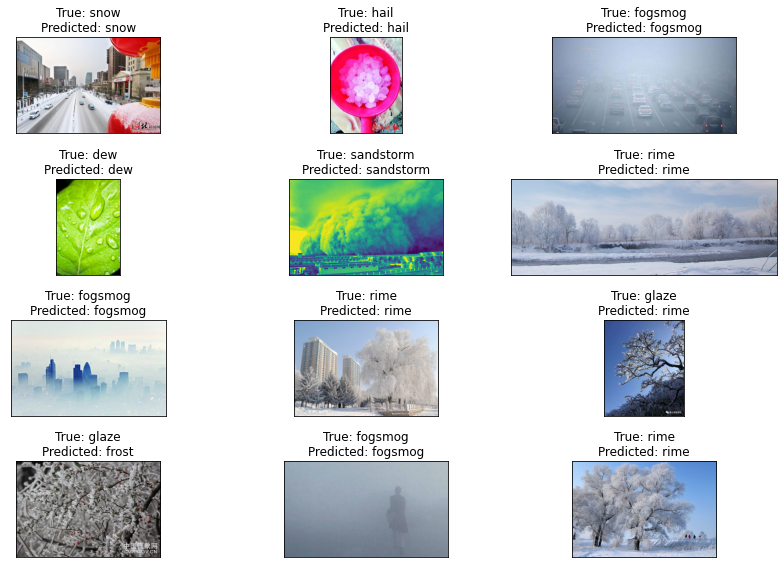

    Test Loss: 0.58960
Test Accuracy: 81.94%


In [20]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet201_pre=preprocess_input
train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = gen(DenseNet201_pre,train_df,test_df)
model_DenseNet201, callback=func(DenseNet201)
history = model_DenseNet201.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_DenseNet201,train_gen_DenseNet201, model_DenseNet201)
result_DenseNet201 = result_test(test_gen_DenseNet201,model_DenseNet201)

In [21]:
output = pd.DataFrame({'Model':['EfficientNetB7','ResNet50','MobileNet','VGG19','Xception','InceptionResNetV2',
                               'VGG16','ResNet101','DenseNet201'],
                      'Accuracy':[result_ENet[1], result_ResNet[1], result_MobileNet[1], result_VGG19[1],
                                  result_Xception[1],result_IRNV2[1],result_VGG16[1],result_ResNet101[1],
                                 result_DenseNet201[1]]})

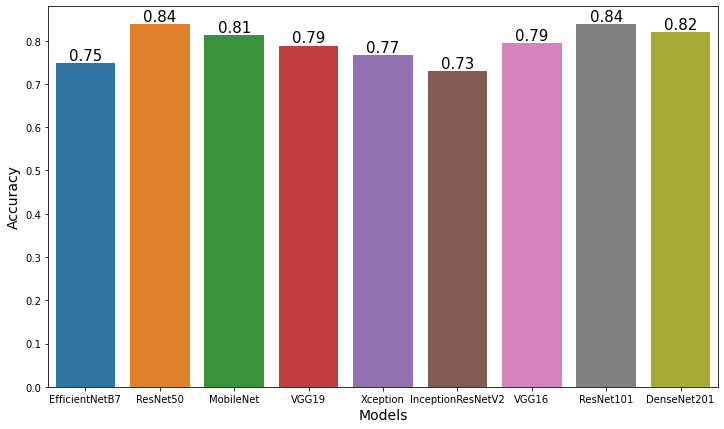

In [22]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()